# [Introduction to Data Science](http://datascience-intro.github.io/1MS041-2023/)    
## 1MS041, 2023 
&copy;2023 Raazesh Sainudiin, Benny Avelin. [Attribution 4.0 International     (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/)

# 13. High-Dimensional Space

## Topics

1. Tail inequalities
- Using LLN to estimate the volume of the unit ball
- The exact volume of the unit ball
- Volume near the equator
- Uniform at random from the unit ball
- Gaussian Annulus theorem
- Random projections (Johnson Lindenstrauss)

### The LLN and volume of the unit ball in $d$ dimensions

The Law of Large Numbers can be used to obtain some information about the volume of a unit ball in $d$ dimensions. To see this let us start with $z$ a d-dimensional random variable where each coordinate is Gaussian with variance $\sigma^2 = 1/(2\pi)$ (you will se why in a bit), then we have
$$
    f(x) = \frac{1}{(2\pi)^{d/2} \sqrt{|\Sigma|}} \exp(-\frac{1}{2} x^T \Sigma^{-1} x)
$$
and $|\Sigma| = det(\Sigma) = det \left (\left ( \frac{1}{2\pi} \right ) I \right ) = \left ( \frac{1}{2\pi} \right )^d$ and thus
$$
    f(x) = \exp(-\pi |x|^2)
$$
from this we get that $f(0) = 1$ and $f(x) \geq e^{-\pi}$ when $|x| \leq 1$, or $x \in B_1(0)$.

Now denote $Z = (X_1,X_2,\ldots, X_n)$, then we see that $|Z|^2 = \sum_i |X_i|^2$ and that all $X_i$ have the same distribution, as such we can apply the LLN and get
$$
    P\left ( \left | \frac{|Z|^2}{d} - \frac{1}{2\pi}\right | \geq \epsilon \right ) \leq \frac{Var(|X_1|^2)}{d \epsilon^2} = \frac{c}{d \epsilon^2}
$$

In particular we get for $\epsilon < 1/(2\pi)$
$$
    \frac{|B_1|}{e^{\pi}} \leq P(Z \in B_1) \leq P\left ( \left | |Z|^2 - \frac{d}{2\pi}\right | \geq d\epsilon \right ) \leq \frac{c}{d \epsilon^2}
$$

Thus the volume of the unit ball will decrease with dimension.

## Lets try it

In [1]:
import numpy as np
dimensions = np.arange(1,20) # Lets try dimension 1 to 20
numberOfExperiments = 10000 # Using 10000 experiments to estimate probability
scale = np.sqrt(1/(2*np.pi))
normals = [np.random.normal(size=(n,numberOfExperiments))*scale for n in dimensions]

In [71]:
##
n=2
normal_1=np.random.normal(size=(n,numberOfExperiments))*scale
normal_1.shape
normal_1[:,1]

array([0.26830797, 0.21007775])

In [72]:

norms = [np.linalg.norm(x,axis=0) for x in normals] # Compute the length
norms[1].shape

(10000,)

In [74]:
##
normal_1_length=np.linalg.norm(normal_1,axis=0)
normal_1_length.shape

[np.linalg.norm(normal_1[:,1],axis=0),np.sqrt(np.sum(normal_1[:,1]**2))]

[0.34076653033857796, 0.8541750199945821]

In [75]:
probInsideUnitBall = [np.mean(x < 1) for x in norms] # Estimate probability

In [76]:
probInsideUnitBall # dimension:1,2,...20
#越高dimension |x|越不容易<1

[0.9872,
 0.9541,
 0.8979,
 0.8223,
 0.7221,
 0.6094,
 0.4877,
 0.3854,
 0.2853,
 0.2118,
 0.1487,
 0.098,
 0.061,
 0.041,
 0.0277,
 0.0133,
 0.009,
 0.0047,
 0.0024]

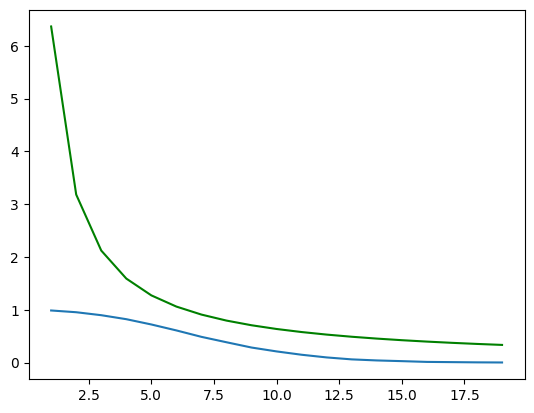

In [5]:
import matplotlib.pyplot as plt
plt.plot(dimensions,probInsideUnitBall)
# The 20 is just for scale, recall the constant c 
# # and the arbitrary \epsilon in our estimate
plt.plot(dimensions,20/(np.pi*dimensions),color='green')

We did a fairly poor job at capturing the behavior, the actual volume seems to be much smaller than our estimate. Lets inspect this further in the coming part.

## Lets also look at the average length

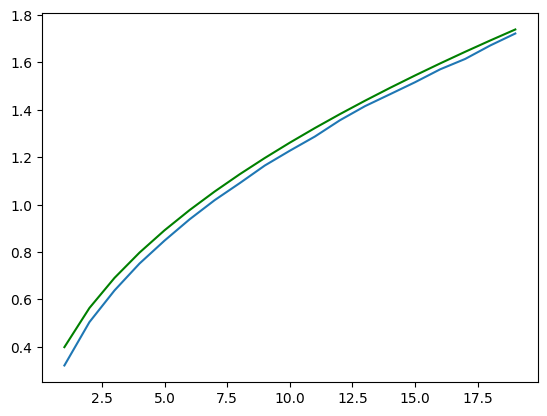

In [6]:
meanNorm = np.mean(np.array(norms),axis=1)
plt.plot(dimensions,meanNorm)
plt.plot(dimensions,np.sqrt(dimensions/(2*np.pi)),color='green')

This seems fairly spot on, interesting!

## The geometry of high dimension

The scaling property of volume. Lets say we have a cube centered at the origin, namely the cube can be written as $Q = [-l,l]^d$ where $d$ is the dimension, the volume is the product of the side-lengths and thus $Vol(Q) = (2l)^d$. Scaling each side of the cube by $(1-\epsilon)$ where $\epsilon$ is a small number gives us that the volume also scales with $(1-\epsilon)^d$, this gives us the formula
$$
    Vol((1-\epsilon)Q)=(1-\epsilon)^d Vol(Q)
$$
Lets divide this equation by the volume of $Q$, we get
$$
    \frac{Vol((1-\epsilon)Q}{Vol(Q)} = (1-\epsilon)^d \to 0
$$
as $d \to \infty$. The conclusion is that most of the volume is located close to the surface of the cube. The same argument holds true for balls as well.

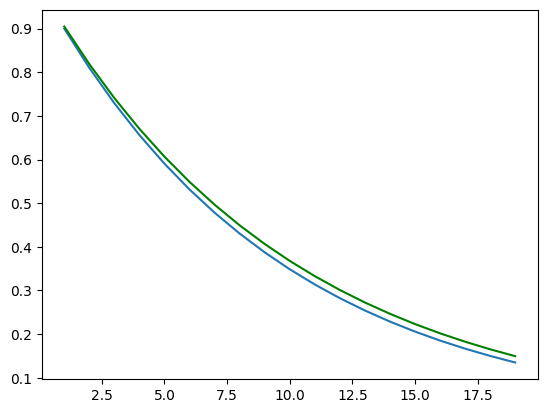

In [7]:
plt.plot(dimensions,np.power(1-0.1,dimensions))
plt.plot(dimensions,np.exp(-0.1*dimensions),color='green')

Based on the above, we can choose $\epsilon = 1/d$ which gives us that most of the volume is contained in the annulus below.

<img src="images/Annulus.png" width="50%"></img>

###  Some preliminaries

Before we begin we need some preliminaries, i.e. we need to recall how to perform change of variables in integration as well as the spherical coordinate system and its Jacobian.

In [8]:
from Utils import showURL
showURL('https://en.wikipedia.org/wiki/Change_of_variables#Coordinate_transformation',300)

In [9]:
showURL('https://en.wikipedia.org/wiki/N-sphere#Spherical_coordinates',300)

## Properties of the unit ball

No discussion about high dimensional geometry is complete without discussion about the volume of the unit ball. Computing the volume of the unit ball requires some effort, but I think we should walk through it, even though its in the book as some comments are in order. Basically the computation follows the following structure

1. Write the volume of the unit ball as an integral of the constant function $1$ over the unit ball
2. Use a radial coordinate system to rewrite that integral so that we get the integral over the surface of a unit ball instead.
3. Compute the integral of the Gaussian kernel in two ways, one using the fact that $\exp(|x|^2) = \exp(|x_1|^2)\exp(|x_2|^2)\ldots \exp(|x_d|^2$, the second one using radial coordinates
4. The radial part of the Gaussian integral gives rise to the Gamma function, which is a generalization of the factorial, the spherical part is just the area of the unit sphere (which is the one we are after).

1. $$ |B_1| = \int_{B_1} dx $$
2. $$ \int_{B_1}dx = \int_{S^d} \int_0^1 \left | \frac{dx}{dr} \right | dr d\Omega $$
where $\left | \frac{dx}{dr} \right |$ is the Jacobian of the change of variables and $d\Omega$ is the surface element on the unit sphere $S^d$.
$$\left | \frac{dx}{dr} \right | = r^{d-1}$$
The conclusion is that 
$$ \int_{B_1}dx = \int_{S^d} \int_0^1 \left | \frac{dx}{dr} \right | dr d\Omega = \frac{A(d)}{d}$$
where $A(d) = \int_{S^d} d\Omega$.

3. This is where we use the Gaussian kernel trick, first note that
$$
    \int_{-\infty}^{\infty} e^{-x^2}dx = \sqrt{\pi}
$$
The normal random variable has a normalizing factor which is $1/\sqrt{pi}$!!!

In [10]:
from sympy import var, integrate
from sympy.core.numbers import oo
from sympy.functions import exp
x = var('x')
integrate(exp(-x**2),(x,-oo,oo))

sqrt(pi)

$$
    \int_{\mathbb{R}^d} e^{-|x|^2} dx = \int_{\mathbb{R}^d} \prod_{i=1}^d e^{-x_i^2} dx = \prod_{i=1}^d \int_{\mathbb{R}^d} e^{-x_i^2} dx_i = \pi^{d/2}
$$
Let us compute the same integral again, but this time using spherical coordinates
$$
    \int_{\mathbb{R}^d} e^{-|x|^2} dx = \int_{S^d} \int_0^\infty e^{-r^2} r^{d-1} dr d\Omega = A(d) \int_0^\infty e^{-r^2} r^{d-1} dr
$$
now doing the change of variables $t = r^2$ we get $dt = 2 r dr$ and thus
$$
    \int_0^\infty e^{-r^2} r^{d-1} dr = \int_0^\infty e^{-t} t^{\frac{d-1}{2}} \frac{1}{2\sqrt{t}} dt = 
    \frac{1}{2} \int_0^\infty e^{-t} t^{\frac{d}{2}-1} dt = \frac{1}{2} \Gamma\left ( \frac{d}{2}\right )
$$

In the above, the $\Gamma$ function is a well known function that has a bunch of interesting properties, but the most important is that, if $k$ is an integer then $\Gamma(k) = (k-1)!$.

Finally we come to the conclusion that the volume of the unit ball in $d$ dimensions is

$$
    V(d) = \frac{2 \pi^{\frac{d}{2}}}{d \Gamma(\frac{d}{2})}
$$

/var/folders/33/2qsqr9pj7r9bm6r8m0hvw9yr0000gn/T/ipykernel_71209/632553846.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(dimensions,2*np.power(np.pi,dimensions/2)/(dimensions*factorial(dimensions/2-1)))


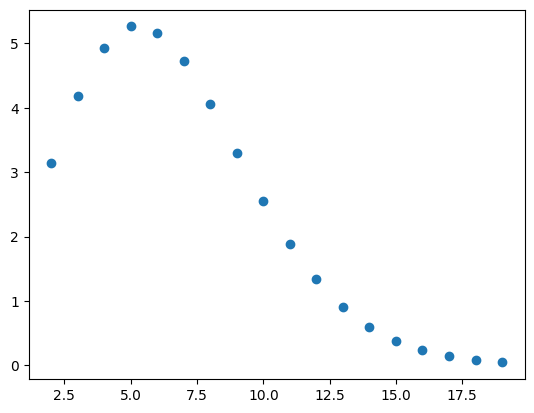

In [11]:
from scipy.special import factorial
plt.scatter(dimensions,2*np.power(np.pi,dimensions/2)/(dimensions*factorial(dimensions/2-1)))
# points([(d,2*pi^(d/2)/(d*factorial(d/2-1))) for d in range(2,20,2)])

In [12]:
showURL('https://en.wikipedia.org/wiki/Gamma_function',400)

## Generating points uniformly at random from a ball

Lets say that we want to generate a uniformly at random variable on the unit circle. One suggestion would be to generate two coordinates $X$ and $Y$ from $\text{Uniform}(-1,1)$ and then projecting $(X,Y)$ onto the unit circle.

In [13]:
XY = np.random.uniform(-1,1,size=(10000,2))

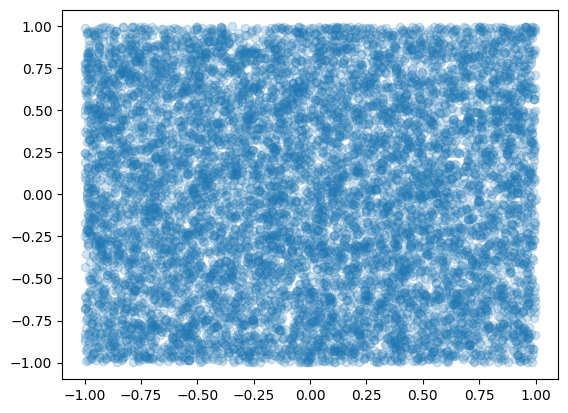

In [14]:
plt.scatter(XY[:,0],XY[:,1],alpha=0.2)

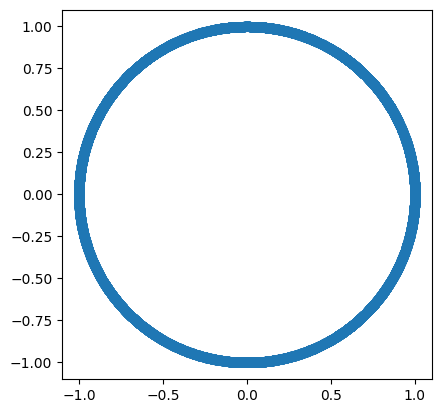

In [15]:
XY = XY / np.linalg.norm(XY,axis=1).reshape(-1,1)
plt.scatter(XY[:,0],XY[:,1])
plt.gca().set_aspect('equal') # To make sure that a circle is a circle and not an ellipse

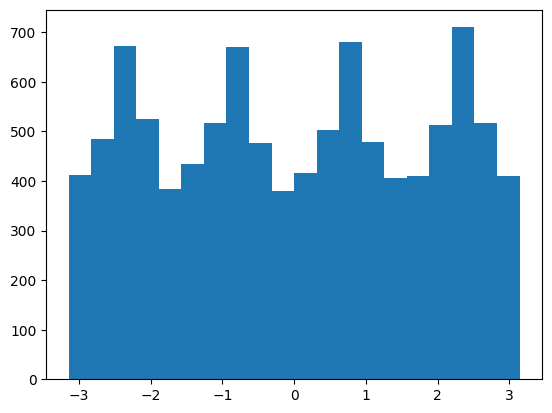

In [16]:
_=plt.hist(np.arctan2(XY[:,1],XY[:,0]),bins=20)

OK, that is not uniform!

In [17]:
showURL('https://numpy.org/doc/stable/reference/generated/numpy.arctan2.html',300)

What could we do? Well, we can discard everything outside the unit square and project those to the circle.

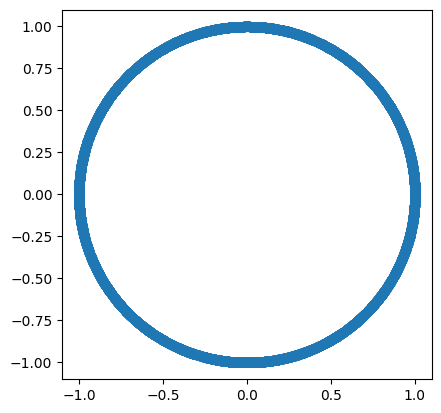

In [18]:
XY = np.random.uniform(-1,1,size=(10000,2))
XY_inCircle = XY[np.linalg.norm(XY,axis=1) < 1]

XY_inCircle = XY_inCircle / np.linalg.norm(XY_inCircle,axis=1).reshape(-1,1)

plt.scatter(XY_inCircle[:,0],XY_inCircle[:,1])
plt.gca().set_aspect('equal') # To make sure that a circle is a circle and not an ellipse

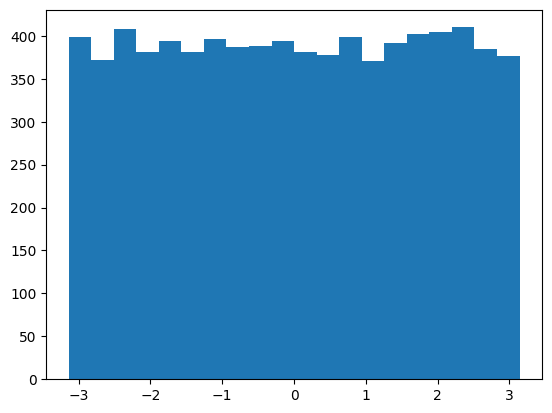

In [19]:
_=plt.hist(np.arctan2(XY_inCircle[:,1],XY_inCircle[:,0]),bins=20)

OK, much better! But this does not work in higher dimensions, why?
Well we already showed that the volume of the unit ball decreases rapidly with dimension while the volume of the cube is $2^d$, so the probability of being inside the unit ball is decreasing very rapidly.

## Uniform at random on the unit sphere (better version)

What was the problem that we had, well basically if we sample from the unit square that distribution is not rotationally symmetric, thus if we sample from a rotationally symmetric distribution then it does not matter, we can just scale any sample to be on the unit circle. A prime example of a rotationally symmetric random variable is the multidimensional Gaussian.

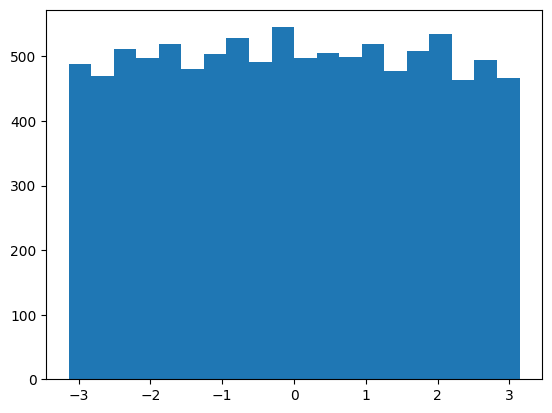

In [20]:
XY = np.random.normal(size=(10000,2))

XY = XY / np.linalg.norm(XY,axis=1).reshape(-1,1)
_=plt.hist(np.arctan2(XY[:,1],XY[:,0]),bins=20)

## How do we generate uniform at random from the unit ball?

In the above we learned how to generate uniform at random from the unit sphere. How can we use this to fill out the entire ball? Perhaps we think that if we take $r \sim \mathrm{Unif}([0,1])$ and $\omega \sim \mathrm{Unif}(\partial B)$, then the final point could be $(r,\omega) \in B$? But is this uniform? Well $(r,\omega) \mid r$ is uniform on $\partial B_r$.
$$
    \lim_{h \to 0}\frac{1}{h} P((r,\omega) \in (B_{t+h} \setminus B_t)) = \lim_{h \to 0}\frac{1}{h} \int_{(B_{t+h} \setminus B_t))} f(r,\omega) dr d\omega = \lim_{h \to 0}\frac{1}{h}\int_{t}^{t+h} \left ( \int_{\partial B} f(r,\omega) d\omega \right ) dr = \int_{\partial B} f(t,\omega) d\omega = f(t)
$$
for some function $f(t)$ that we will now find.

Now for a uniform distribution the probability of being in a set is proportional to its volume and hence
$$
    \lim_{h \to 0} \frac{1}{h} P((r,\omega) \in (B_{t+h} \setminus B_t)) = \lim_{h \to 0} \frac{|B_{t+h} \setminus B_t|}{h |B|} = c_0 \lim_{h \to 0} \frac{(t+h)^d-s^d}{h} = c_1 t^{d-1}
$$
hence
$$
    f(t) = c_2 t^{d-1}
$$
To find $c_2$ we know that
$$
    \int_0^1 f(t) dt = 1 \implies c_2 = d
$$
Lets try this in 2-d and see what happens

In [21]:
import numpy as np
XY = np.random.normal(size=(100000,2)) # Spherical Gaussian with unit variance in each coordinate in R^2

XY = XY / np.linalg.norm(XY,axis=1).reshape(-1,1) # Make all vector unit length

r = np.random.uniform(size=(XY.shape[0],1)) # Sample the radii uniformly from [0,1]
uniform_ball = np.sqrt(r)*XY # Consider the correctly scaled radius

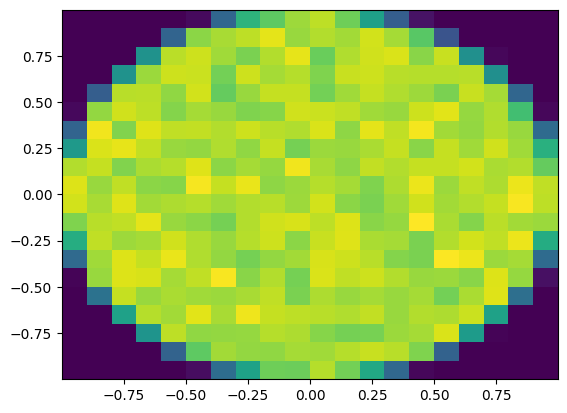

In [22]:
_=plt.hist2d(uniform_ball[:,0],uniform_ball[:,1],bins=20)

## Gaussian Annulus theorem

Remember that for a d-dimensional spherical Gaussian with standard deviation $1$ in each dimension satisfies
$$
    E[|x|^2] = d.
$$
Thus one could expect that $|x|$ concentrates around $\sqrt{d}$. The next theorem makes this rigorous, as well as providing tail bounds.

>For a $d$-dimensional spherical Gaussian with unit variance in each direction, for any $\beta < \sqrt{d}$, all but at most $3 e^{-c\beta^2}$ of the probability mass lies within the annulus
> $$\sqrt{d} - \beta \leq |x| \leq \sqrt{d} + \beta$$
> where $c$ is a fixed positive constant.

### Proof

The proof follows from a concentration inequality for sums of random variables, see the master tails bound. Whenever we have sums of random variables usually have a lot of cancellation, i.e. all the variables are not big at the same time. The more variables the smaller the tails.

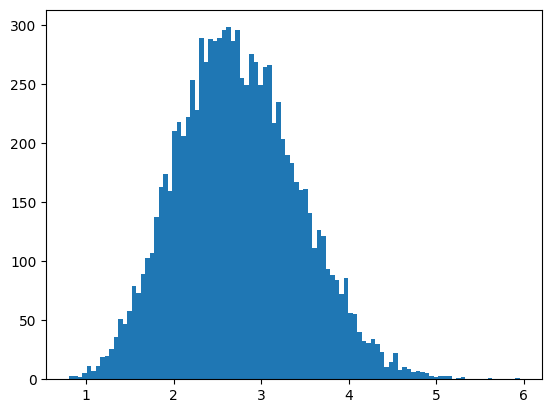

In [23]:
d = 10^2
n_samples = 10000
dGaussian = np.random.normal(size=(n_samples,d))
dGaussianNorm = np.linalg.norm(dGaussian,axis=1)
_=plt.hist(dGaussianNorm,bins=100)

## K-Nearest Neighbors Algorithm

The $k$-nearest neighbor algorithm is a particularly simple method that is nonparametric and in fact requires no training, or, to put it bluntly, it uses training data as a base of the model, but does not perform any computation for training. So what is actually going on here?

* For **classification** we proceed as follows: Let us say we are given a dataset $X$ with labels $y$, whenever we are given a new point $x$ and wish to predict which class this point corresponds to, we simply look at the $k$-nearest neighbors and find the most common class within those.
* For **regression** we proceed as follows: Let us say we are given a dataset $X$ with targets $y$, whenever we are given a new point $x$ and wish to predict which target value this point corresponds to, we simply look at the $k$-nearest neighbors and take the average of those points target value.

How do we compute the $k$ nearest neighbours? First we start with a distance matrix 

In [24]:
# For simplicity we will construct a classification dataset with two features and two classes

X_data = np.array([[ 0.36731074, -0.26731719, -0.72426635, -0.54930901, -0.47614201,
                     0.1327083 ,  1.30847308,  0.19501328, -0.99805696,  0.14979754],
                   [ 0.37311239,  0.56515267, -0.1917514 , -0.14742026,  0.2890942 ,
                    -0.02590534, -0.53987907,  0.70816002, -0.92185638,  0.92011316],
                   [-0.30774856,  0.84222474,  1.36755686,  0.2035808 ,  0.91745894,
                     2.39470366, -0.11227247, -0.36218045,  0.96482992,  0.94849202],
                   [-0.66770717, -0.93943336,  1.12547913, -0.48933722, -0.21269764,
                    -0.80459114, -0.33914025,  0.31216994,  1.78198367, -0.54211499],
                   [ 0.40071561,  0.40020999, -2.30125766, -0.33763234, -0.7319695 ,
                     1.25647226,  0.66023155, -0.35087189, -1.34430587, -1.96996738]])

y_data = np.array([0,0,1,1,0])

Let $S = \{X_1,X_2,\ldots,X_n\}$ where each $X_i \in \mathbb{R}^d$, then the distance matrix is denoted as
$$
    D_{mat}(S) = \begin{bmatrix}
        |X_1-X_1| & |X_1-X_2| & \ldots & |X_1-X_n| \\
        |X_2-X_1| & |X_2-X_2| & \ldots & |X_2-X_n| \\
        \vdots \\
        |X_n-X_1| & |X_n-X_2| & \ldots & |X_n-X_n| \\
    \end{bmatrix}
$$

In [25]:
XX = X_data.reshape(X_data.shape[0],1,X_data.shape[1])-X_data.reshape(1,X_data.shape[0],X_data.shape[1])
distance_matrix = np.linalg.norm(XX,axis=2)

In [26]:
distance_matrix

array([[0.        , 2.45515562, 4.52856743, 4.10265945, 3.10454658],
       [2.45515562, 0.        , 3.77333293, 3.96272646, 4.27715699],
       [4.52856743, 3.77333293, 0.        , 4.33026799, 5.73698516],
       [4.10265945, 3.96272646, 4.33026799, 0.        , 5.69825883],
       [3.10454658, 4.27715699, 5.73698516, 5.69825883, 0.        ]])

How do we find the k-nearest neighbors?

Lets make an example, let $k= 2$ and consider $X_1$ in the above, we see that the two closest points are $X_2,X_5$.
For $X_2$ we have $X_1,X_3$ etc.

But, if all we want to do is to compute the k-nearest neighbors from $X$ to $S$, we can compute $|X-X_i|$ for all i and sort the list (for instance), then choose the bottom $k$.

We can think of $S$ as a database and $X$ as a query:
> What is the k nearest neighbors of X?

How many computations are needed for such a query? If we use the technique above then we get
1. $C n d$, where I think $C$ is 4, to compute the distances
2. $n \log n$ to sort

Total $C nd + n \log n$, we cannot really make $n$ smaller, but what if we could make $d$ smaller?

## Random Projection and Johnson-Lindenstrauss Lemma
### Random Projection Theorem
> Let $v$ be a fixed vector in $\mathbb{R}^d$, then there exists a constant $c > 0$ such that if we for a fix $\epsilon \in (0,1)$
> pick $k$ Gaussian vectors $u_1,\ldots, u_k \in \mathbb{R}^d$ and form the function
> $$f(v) = (u_1 \cdot v, \ldots, u_k \cdot v): \mathbb{R}^d \to \mathbb{R}^k,$$
> then
> $$P\left (\left | |f(v)| - \sqrt{k} |v| \right |  \geq \epsilon \sqrt{k}|v| \right ) \leq 3 e^{-ck\epsilon^2}$$

Lets simulate this lemma and see what happens. Try increasing d and see what happens to the distribution, then increase k and see what happens.

In [27]:
# Lets simulate
import numpy as np
from ipywidgets import interact, IntSlider
@interact
def _(d=IntSlider(100,100,2000,100),k=IntSlider(2,2,100,1)):
    np.random.seed(1)
    v_pre = np.random.normal(size=d)
    v = v_pre / np.linalg.norm(v_pre)

    print("v has length: %.2f" % np.linalg.norm(v))

    num_simulations = 300

    error = []

    for i in range(num_simulations):
        uis = np.random.normal(size=(k,d))
        f = uis@v
        error.append(abs(np.linalg.norm(f)-np.linalg.norm(v)*np.sqrt(k))/(np.linalg.norm(v)*np.sqrt(k)))
    _=plt.hist(error)
    # P=histogram(error)
    # P.xmax(1)
    # P.show()

interactive(children=(IntSlider(value=100, description='d', max=2000, min=100, step=100), IntSlider(value=2, d…

### What can you get from the above simulation?
Is this a good way of projecting? How high dimension do we really need?

### You try at home
Can you find a better way of using numpy to perform the simulation above faster? So that we quickly can simulate 10000 examples?

### Proof

Lets consider unit vectors $v$ as in the simulation above. Note now that
$$
    u_i \cdot v = \sum_{j=1}^d (u_i)_j v_j
$$
each $(u_i)_j$ is N(0,1) and independent of each other, as such $u_i \cdot v$ is N(0,1). From this follows that $f(v)$ is a spherical Gaussian in $\mathbb{R}^k$, as such the theorem follows from the Gaussian Annulus theorem.

### Johnson-Lindenstrauss Lemma
>For any $0 < \epsilon < 1$  and any integer $n$, let $k \geq \frac{3}{c\epsilon^2} \ln n$ where $c$ is as in the random projection theorem. For any set of $n$ points $\{v_1,\ldots,v_n\}$ in $\mathbb{R}^d$ then the random projection defined in the random projection theorem satisfies
>$$P((1-\epsilon) \sqrt{k} |v_i-v_j| \leq |f(v_i-v_j)| \leq (1+\epsilon) \sqrt{k} |v_i-v_j|: \forall i, j) \geq 1-\frac{3 }{2 n}$$

#### Proof
For any fixed $v_i,v_j$ we can apply the random projection theorem and obtain that
$$
    P\left (\left | |f(v_i-v_j)| - \sqrt{k} |v_i-v_j| \right | > \epsilon |v_i-v_j|\right) \leq 3e^{-c k \epsilon^2}
$$
There are $\binom{n}{2} < n^2/2$ pairs to consider, so  using the union bound we get
$$
    P\left (\left | |f(v_i-v_j)| - \sqrt{k} |v_i-v_j| \right | > \epsilon |v_i-v_j|: \exists i, j\right)  \leq \frac{3 n^2}{2} e^{-c k \epsilon^2}
$$
Choose $k \geq \frac{3}{c \epsilon^2}$ then
$$
    P\left (\left | |f(v_i-v_j)| - \sqrt{k} |v_i-v_j| \right | > \epsilon |v_i-v_j|: \exists i, j\right)  \leq \frac{3 }{2 n}
$$
which gives
$$
    P((1-\epsilon) \sqrt{k} |v_i-v_j| \leq |f(v_i-v_j)| \leq (1+\epsilon) \sqrt{k} |v_i-v_j|: \forall i, j) \geq 1-\frac{3 }{2 n}
$$

#### YouTry:
Perform a simulation of the Johnson-Lindenstrauss lemma. You can use the following set of points

In [78]:
import numpy as np
d = 1000
n = 100
vis = np.random.normal(size=(n,d))

You will need to find a way to fairly quickly loop over all pairs

## Exam example problem

The goal of this problem is to implement your own random projection function, i.e. same as in the random projection theorem and Johnson Lindenstrauss. Below you will find a function template, as always fill in XXX.

Some notes, the input will be a numpy array and the output should also be a numpy array. The format for the input is `(n_samples, d)` and the output should be of the form `(n_samples, k)`.

In [106]:
# Do not rename the function below just replace what is XXX
def random_projection(X,d,k):
    '''Perform a random projection of the dataset X from 
    d-dimensions into k-dimensions'''
    assert X.shape[1] == d, "The array X does not have the shape (n_samples,d)"
    


    output=[]
    for i in range(X.shape[0]):
        v_pre = X[i]
        v = v_pre / np.linalg.norm(v_pre)
        #print("v has length: %.2f" % np.linalg.norm(v))
        uis = np.random.normal(size=(k,d))
        f = uis@v
        output.append(f)

    return np.array(output)


    np.random.seed(1)
    v_pre = np.random.normal(size=d)
    v = v_pre / np.linalg.norm(v_pre)

    print("v has length: %.2f" % np.linalg.norm(v))

    num_simulations = 300

    error = []

    for i in range(num_simulations):
        uis = np.random.normal(size=(k,d))
        f = uis@v
        error.append(abs(np.linalg.norm(f)-np.linalg.norm(v)*np.sqrt(k))/(np.linalg.norm(v)*np.sqrt(k)))
    _=plt.hist(error)

In [107]:
# small test to see that you output the correct shape
import numpy as np
X_test = np.array([[1,1],[2,1],[3,1],[4,1]])
try:
    assert(random_projection(X_test,2,1).shape == (X_test.shape[0],1))
    print("You are outputting the correct dimension, hopefully it is correct.")
except AssertionError:
    print("Try again! and make sure you are producing an output of (n_samples,k)")

You are outputting the correct dimension, hopefully it is correct.


In [108]:
(X_test.shape[0],1)
random_projection(X_test,2,1)

array([[ 2.99794486],
       [-1.56017565],
       [-0.483914  ],
       [ 0.0534902 ]])

In [109]:
local_points=0
from math import sqrt

try:
    A = np.array([1,0]).reshape(1,-1)
    B = np.array([0,1]).reshape(1,-1)
    n_test = 1000
    SampA = np.array([random_projection(A,2,1).reshape(-1)[0] for i in range(n_test)])
    assert np.abs(SampA.mean()) < 8*1/sqrt(n_test)
    assert np.abs(SampA.var()) < 1+8*1/sqrt(n_test)
    SampB = np.array([random_projection(B,2,1).reshape(-1)[0] for i in range(n_test)])
    assert np.abs(SampB.mean()) < 8*1/sqrt(n_test)
    X_test2 = np.zeros((100,2300))
    assert(random_projection(X_test2,2300,30).shape == (X_test2.shape[0],30))    
except Exception as e:
    print(e)
    print("You have failed to pass the test for this problem. Try again..")
    print("You are either not randomizing correctly or you are not projecting to the right space")
else:
    print("You have passed the test for this problem, congratulations!")
    local_points += 1
finally:
    print("The number of points you have scored for this problem so far = "+str(local_points))

You have passed the test for this problem, congratulations!
The number of points you have scored for this problem so far = 1


## High dimensional data-set and nearest neighbor search

Use your random projection implementation from the assignment above and explore this dataset.

### Description

Molecular Classification of Cancer: Class Discovery and Class Prediction by Gene Expression Monitoring.

Science, VOL 286, pp. 531-537, 15 October 1999. Web supplement to the article

T.R. Golub, D. K. Slonim, P. Tamayo, C. Huard, M. Gaasenbeek, J. P. Mesirov, H. Coller, M. L. Loh, J. R. Downing, M. A. Caligiuri, C. D. Bloomfield, E. S. Lander.

In [ ]:
import csv
features = []
labels = []
with open('data/leukemia.csv',mode='r') as f:
    reader = csv.reader(f)
    header=next(f)
    for row in reader:
        features.append(np.array(row[:-1],dtype=float))
        labels.append((row[-1] == 'ALL')*1)

In [ ]:
X = np.stack(features,axis=0)
Y = np.array(labels)

In [ ]:
X.shape

For those who cannot install sklearn we can use the implementation found at https://github.com/mavaladezt/kNN-from-Scratch

In [ ]:
def knn_distances(xTrain,xTest,k):
    """
    Finds the k nearest neighbors of xTest in xTrain.
    Input:
    xTrain = n x d matrix. n=rows and d=features
    xTest = m x d matrix. m=rows and d=features (same amount of features as xTrain)
    k = number of nearest neighbors to be found
    Output:
    dists = distances between all xTrain and all XTest points. Size of n x m
    indices = k x m matrix with the indices of the yTrain labels that represent the point
    """
    #the following formula calculates the Euclidean distances.
    import numpy as np
    distances = -2 * xTrain@xTest.T + np.sum(xTest**2,axis=1) + np.sum(xTrain**2,axis=1)[:, np.newaxis]
    #because of float precision, some small numbers can become negatives. Need to be replace with 0.
    distances[distances < 0] = 0
    distances = distances**.5
    indices = np.argsort(distances, 0) #get indices of sorted items
    distances = np.sort(distances,0) #distances sorted in axis 0
    #returning the top-k closest distances.
    return indices[0:k,:], distances[0:k,:]

def knn_predictions(xTrain,yTrain,xTest=None,k=3):
    """
    Uses xTrain and yTrain to predict xTest.
    Input:
    xTrain = n x d matrix. n=rows and d=features
    yTrain = n x 1 array. n=rows with label value
    xTest = m x d matrix. m=rows and d=features (same amount of features as xTrain)
    k = number of nearest neighbors to be found
    Output:
    predictions = predicted labels, ie preds(i) is the predicted label of xTest(i,:)
    """
    import numpy as np
    if (xTest == None):
        xTest = xTrain
        
    indices, distances = knn_distances(xTrain,xTest,k)
    yTrain = yTrain.flatten()
    rows, columns = indices.shape
    predictions = list()
    for j in range(columns):
        temp = list()
        for i in range(rows):
            cell = indices[i][j]
            temp.append(yTrain[cell])
        predictions.append(max(temp,key=temp.count)) #this is the key function, brings the mode value
    predictions=np.array(predictions)
    return predictions

def score(prediction,true_values):
    return np.sum(prediction == true_values)/len(prediction)

In [ ]:
score(knn_predictions(X,Y,k=5),Y)

From this we see that there is a high relation between which items are close and what is the class. Lets check how long time the query takes

In [ ]:
%%timeit

score(knn_predictions(X,Y,k=5),Y)

Lets now project this to a smaller dimensional space, try different values and rerun to see what happens

In [ ]:
def random_projection(X,d,k):
    '''Perform a random projection of the dataset X from 
    d-dimensions into k-dimensions'''
    assert X.shape[1] == d, "The array X does not have the shape (n_samples,d)"
    u = np.random.normal(size=(k,d))
    uX = X@(u.T)
    return uX
k = 3
X_proj_kd = random_projection(X,X.shape[1],k)

In [ ]:
score(knn_predictions(X_proj_kd,Y,k=5),Y)

For 1000 dimension there is a high change due to JL lemma that the distances are preserved up to a small epsilon and as such we should not change what is the nearest neighbour, thus the performance can be exactly the same.

In [ ]:
%%timeit

score(knn_predictions(X_proj_kd,Y,k=5),Y)

However we see that the run-time is waay faster. Try also to visualize the projection in dimension 2 and 3, to get a feel for how the projection changes when you rerun the random projection.

In [ ]:
def standardScaler(X_in):
    '''Takes an array of shape (n_samples,n_features) and centers and normalizes the data'''
    X_out = (X_in-np.mean(X_in,axis=0))/np.std(X_in,axis=0)
    return X_out

In [ ]:
if (k in [2,3]):
    X_proj_kd_rescale = standardScaler(X_proj_kd)
    class0 = X_proj_kd_rescale[Y==0]
    class1 = X_proj_kd_rescale[Y==1]
    from Utils import scatter3d
    fig = scatter3d(class0[:,0],class0[:,1],class0[:,2],c='blue')
    fig = scatter3d(class1[:,0],class1[:,1],class1[:,2],c='red',fig=fig)
    fig.show()